In [70]:
from dataloader import ReyesDataset
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

In [71]:
# timer inicial do notebook
import time
start = time.time()

In [72]:
train = ReyesDataset("../dataset/UCI/train.csv")
print(train.X.shape)
# calcula o hierariquico de X
Z = linkage(train.X[:,0,:].reshape(train.X.shape[0],train.X.shape[-1]), 'ward')

(7352, 9, 128)


# method
"single": nearest point
"complete": farthest point
"average": média das distancias
"weighted"
"centroid"
"median"
"ward"

# metric

eucliedeana
pra caramba
personalizavel

# optimal_ordering
minimiza as distancias entre elementos consecutivos da tabela

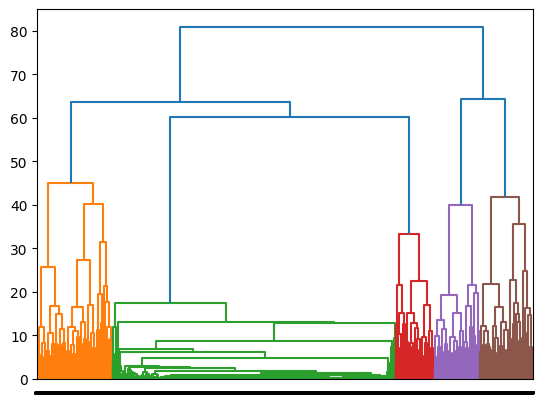

<Figure size 2500x1000 with 0 Axes>

In [73]:
dendrogram(Z, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

In [74]:
def plotar_grupo(grupo, embeddings, labels):
    intervalo_x = [np.min(embeddings[:,0]), np.max(embeddings[:,0])]
    intervalo_y = [np.min(embeddings[:,1]), np.max(embeddings[:,1])]

    names = {0: 'WALKING', 1: 'WALKING UPSTAIRS', 2: 'WALKING DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING', 6: 'RUNNING'}
    colors = {0: 'darkorange', 1: 'magenta', 2: 'purple', 3: 'blue', 4: 'green', 5: 'brown', 6: 'red'}

    # traduz labels para um vetor de RGB
    labels = np.array([colors[label] for label in labels])
    print(labels.shape)

    plt.scatter(embeddings[grupo,0], embeddings[grupo,1], c=labels[grupo], alpha=0.5,)
    # mostra a legenda com base nos nomes
    for i in range(7):
        plt.scatter([], [], c=colors[i], label=names[i])

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    plt.xlim(intervalo_x)
    plt.ylim(intervalo_y)
    plt.show()


def plotar_completo(X_embedded_latent, labels):

    # imita o funcionamento da funcao acima
    intervalo_x = [np.min(X_embedded_latent[:,0]), np.max(X_embedded_latent[:,0])]
    intervalo_y = [np.min(X_embedded_latent[:,1]), np.max(X_embedded_latent[:,1])]

    names = {0: 'WALKING', 1: 'WALKING UPSTAIRS', 2: 'WALKING DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING'} #, 6: 'RUNNING'}
    colors = {0: 'darkorange', 1: 'magenta', 2: 'purple', 3: 'blue', 4: 'green', 5: 'brown'}#, 6: 'red'}

    # traduz labels para um vetor de RGB
    labels = np.array([colors[label] for label in labels])

    plt.scatter(X_embedded_latent[:,0], X_embedded_latent[:,1], c=labels, alpha=0.5,)
    for i in range(7):
        plt.scatter([], [], c=colors[i], label=names[i])
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    plt.xlim(intervalo_x)
    plt.ylim(intervalo_y)
    plt.show()


(7352,)


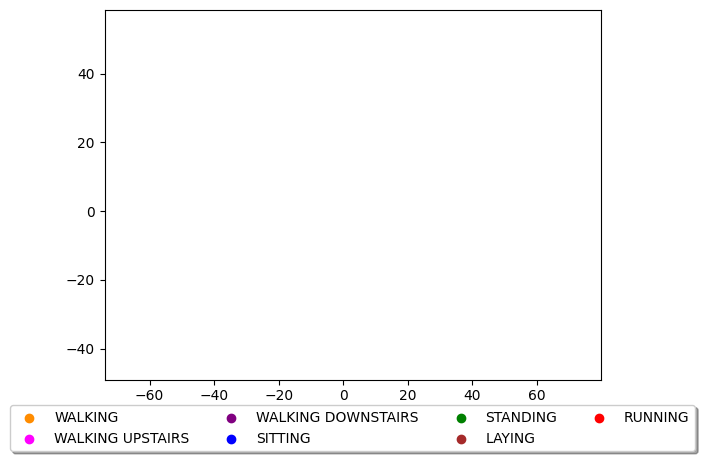

(7352,)


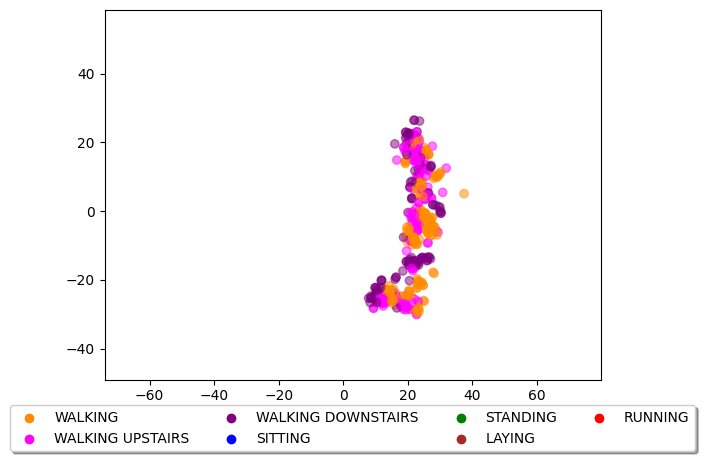

(7352,)


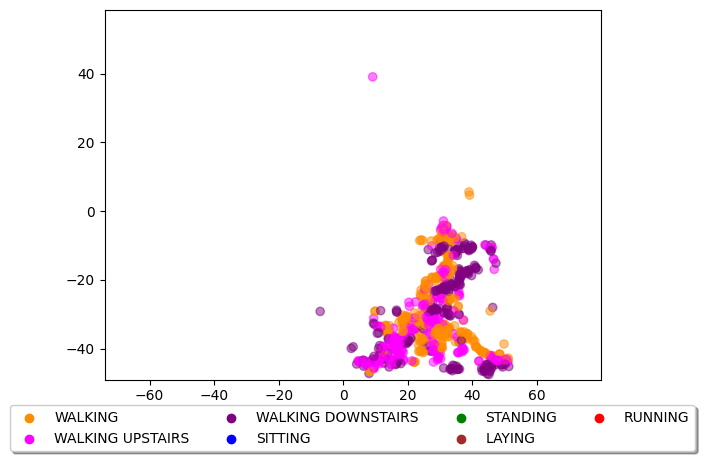

(7352,)


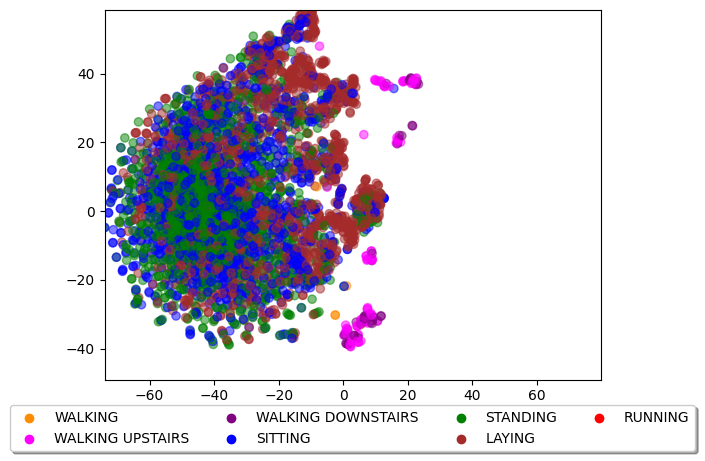

(7352,)


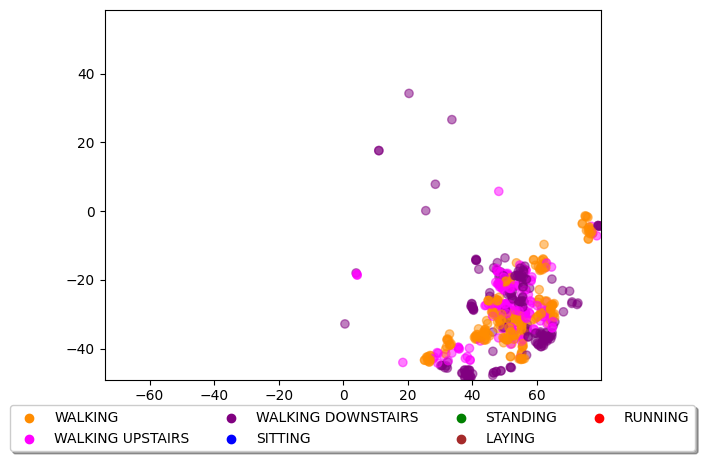

(7352,)


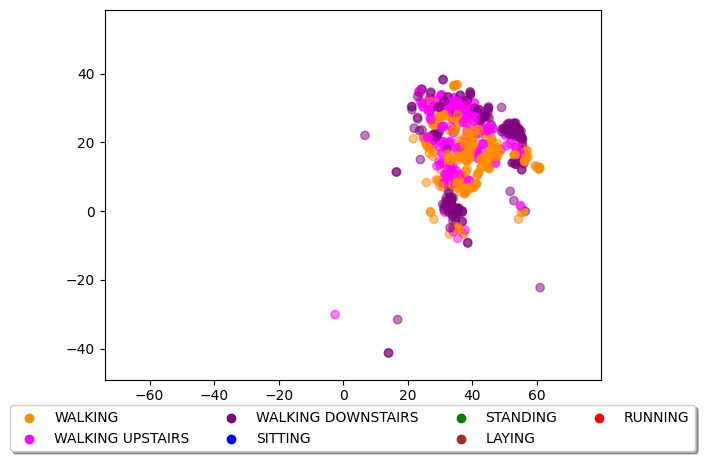

KeyError: 6

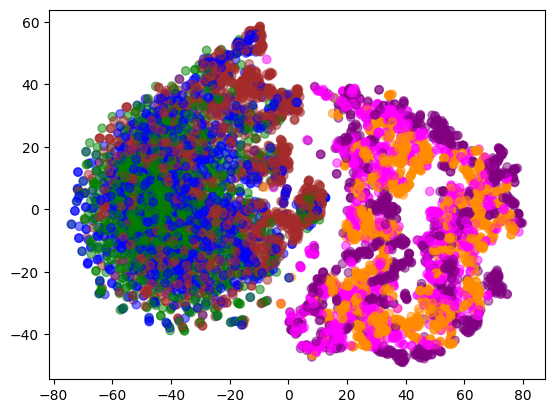

In [76]:
# mostra o tsne desses dados
from sklearn.manifold import TSNE

X = train.X[:,0,:].reshape(train.X.shape[0],train.X.shape[-1])
X_embedded = TSNE(n_components=2).fit_transform(X)


# printa os grupos com o corte em 4 grupos
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, 6, criterion='maxclust')
# obtem os indices dos grupos
for i in range(len(np.unique(clusters))):
    group = np.where(clusters == i)[0]
    plotar_grupo(group, X_embedded, train.Y)

plotar_completo(X_embedded, train.Y)

In [ ]:
from scipy.fftpack import fft

X_freq = np.abs(fft(X))
X_freq = X_freq[:,1:X.shape[1]//2]
X_embedded_freq = TSNE(n_components=2).fit_transform(X_freq)


Z_freq = linkage(X_freq[:,0,:].reshape(X_freq.shape[0],X_freq.shape[-1]), 'ward')
clusters = fcluster(Z_freq, 6, criterion='maxclust')
# obtem os indices dos grupos
for i in range(len(np.unique(clusters))):
    group = np.where(clusters == i)[0]
    plotar_grupo(group, X_embedded, train.Y)

plotar_completo(X_embedded_freq, train.Y)

In [10]:
Z_freq = linkage(X_freq, 'ward')

In [ ]:
dendrogram(Z_freq, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

In [ ]:
import torch
import lightning as L
from tfc import NTXentLoss_poly, TFC_Model, TFC_Backbone
from dataloader import ReyesModule
import os

# Build the pretext model, the pretext datamodule, and the trainer
pretext_model = TFC_Model(backbone=TFC_Backbone(), pred_head=None, loss = NTXentLoss_poly("cuda", 8, 0.2, True)) # batch size 8
pretext_datamodule = ReyesModule(root_data_dir=f"../dataset/UCI/", batch_size=8)
lightning_trainer = L.Trainer(
    accelerator="gpu",
    # max_epochs=40,
    max_epochs=1,
    max_steps=-1,
    enable_checkpointing=True, 
    logger=True)


# se weights/pretrained_backbone_weights.pth ja existir, carrega
if os.path.exists("weights/pretrained_backbone_weights.pth"):
    pretext_model.backbone.load_state_dict(torch.load("weights/pretrained_backbone_weights.pth"))
else:
    # Fit the pretext model using the pretext_datamodule
    lightning_trainer.fit(pretext_model, pretext_datamodule)

    # Save the backbone weights
    torch.save(pretext_model.backbone.state_dict(), "weights/pretrained_backbone_weights.pth")

In [ ]:
print(train.X.shape)
print(train.Y.shape)

output = pretext_model(torch.tensor(train.X.astype(np.float32)))
# formato: h_t, z_t, h_f, z_f
# concatena z_t e z_f
latent = torch.cat((output[1], output[3]), dim=1)

In [14]:
# mostra o espaço latente com as labels
X_embedded_latent = TSNE(n_components=2).fit_transform(latent.detach().numpy())

In [ ]:
plotar_completo(X_embedded_latent, train.Y)

In [61]:
# calcula o hierariquico de latent
Z_latent = linkage(latent.detach().numpy(), "ward")

In [ ]:
# mostra o dendograma
dendrogram(Z_latent, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

In [62]:
# printa os grupos com o corte em 4 grupos
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z_latent, 4, criterion='maxclust')
# obtem os indices dos grupos
for i in range(len(np.unique(clusters))):
    group = np.where(clusters == i)[0]
    plotar_grupo(group, X_embedded, train.Y)

plotar_completo(X_embedded_latent, train.Y)

In [ ]:
final = time.time()
print("Tempo total de execução: ", final - start)